In [1]:
from copy import copy
from matplotlib import pyplot as plt
from matplotlib import patches
from multiprocessing import Pool
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
def obtain_xvg(args):
    rep, force = args
    xvg_lines = []
    force_str = str(force // 10 if force % 10 == 0 else force / 10)
    
    skip_counter = 0
    with open("/nfsdata/artem/1sq0/dists/{}_{}.xvg".format(rep, force_str), "r") as f:
        for line in f:
            if skip_counter < 24:
                skip_counter += 1
                continue

            xvg_lines.append([float(s) for s in line.split()])
            
    xvg_arr = np.array(xvg_lines)[:, 1:]
    np.savez_compressed("/data/analytics/catch_bonds/1sq0/dists_npz/{}_{}.npz".format(rep, force_str), xvg_arr)

def get_pair(num, first_chain_len):
    f = num % first_chain_len
    s = num // first_chain_len
    return (f + 1, s + 1)

def get_index(f, s, first_chain_len):
    return (s - 1) * first_chain_len + (f - 1)

In [3]:
FIRST_CHAIN = 198
SECOND_CHAIN = 265
MAX_DIST = 0.3
MIN_OCCUPANCY = 0.1

PAIRS = FIRST_CHAIN * SECOND_CHAIN
FORCES = 21
REPS = 10
FRAMES = 1000

dists_arrs = []

In [ ]:
args = [(rep, force) for rep in range(1, REPS + 1) for force in range(FORCES)]
with Pool(50) as p:
    for i, r in tqdm(enumerate(p.imap(obtain_xvg, args)), total=len(args)):
        pass

In [ ]:
whole_arr = np.zeros((REPS, FORCES, FRAMES, PAIRS), dtype=np.float16)

for rep in tqdm(range(1, REPS + 1)):
    for force in range(FORCES):
        force_str = str(force // 10 if force % 10 == 0 else force / 10)
        npz_file = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/{}_{}.npz".format(rep, force_str))
        whole_arr[rep - 1, force, :, :] = npz_file["arr_0"]

In [ ]:
np.savez_compressed("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz", whole_arr)

In [4]:
whole_arr = np.load("/data/analytics/catch_bonds/1sq0/dists_npz/whole.npz")["arr_0"]

drop R3_35, R4_35, R8_28, R10_42

In [59]:
whole_arr.shape

(10, 21, 1000, 52470)

In [83]:
candidates = set()

for f in tqdm(range(FORCES)):
    for i in range(whole_arr.shape[3]):
        p_10 = np.percentile(whole_arr[:, f, :, i].flatten(), 10)
        if p_10 < .5:
            candidates.add(i)

In [86]:
z_f_percentiles = [[np.percentile(whole_arr[:, 0, :, c], 5 * p) for p in range(1, 20)] for c in candidates]
diffs_dict = dict()

for c_i, c in enumerate(candidates):
    for f in range(whole_arr.shape[1]):
        diffs_dict[(c, f)] = 0
        for p in range(1, 20):
            cur_p = np.percentile(whole_arr[:, f, :, c], 5 * p)
            cur_diff = cur_p - z_f_percentiles[c_i][p - 1]
            diffs_dict[(c, f)] += cur_diff

In [114]:
cand_tuples = sorted([(get_pair(k[0], FIRST_CHAIN), k[1], v) for k, v in diffs_dict.items()], key=lambda t: t[2])
cand_tuples = [c for c in cand_tuples if c[2] < -1.5]
cand_tuples

[((64, 230), 3, -2.96944580078125),
 ((106, 14), 4, -2.9654785156250005),
 ((106, 37), 4, -2.80048828125),
 ((106, 7), 4, -2.6904785156249975),
 ((64, 237), 4, -2.364453125),
 ((64, 130), 2, -2.3441894531249994),
 ((104, 103), 3, -2.317626953125),
 ((64, 230), 4, -2.2526367187499994),
 ((103, 127), 3, -2.241943359374999),
 ((64, 237), 3, -2.23828125),
 ((64, 130), 3, -2.137109375),
 ((64, 235), 4, -2.0128906249999994),
 ((107, 9), 6, -1.9193115234374982),
 ((64, 230), 2, -1.8310058593750003),
 ((104, 81), 3, -1.8241210937499996),
 ((106, 35), 4, -1.8092773437500012),
 ((104, 127), 3, -1.8060546875000008),
 ((198, 8), 3, -1.7952636718750012),
 ((106, 9), 4, -1.7319824218750006),
 ((66, 5), 1, -1.6879150390624993),
 ((45, 10), 1, -1.6762207031250007),
 ((106, 14), 6, -1.6671386718750005),
 ((104, 104), 3, -1.6562988281250013),
 ((44, 14), 1, -1.6486083984375004),
 ((103, 130), 4, -1.5934326171874984),
 ((106, 7), 6, -1.5499511718749979)]

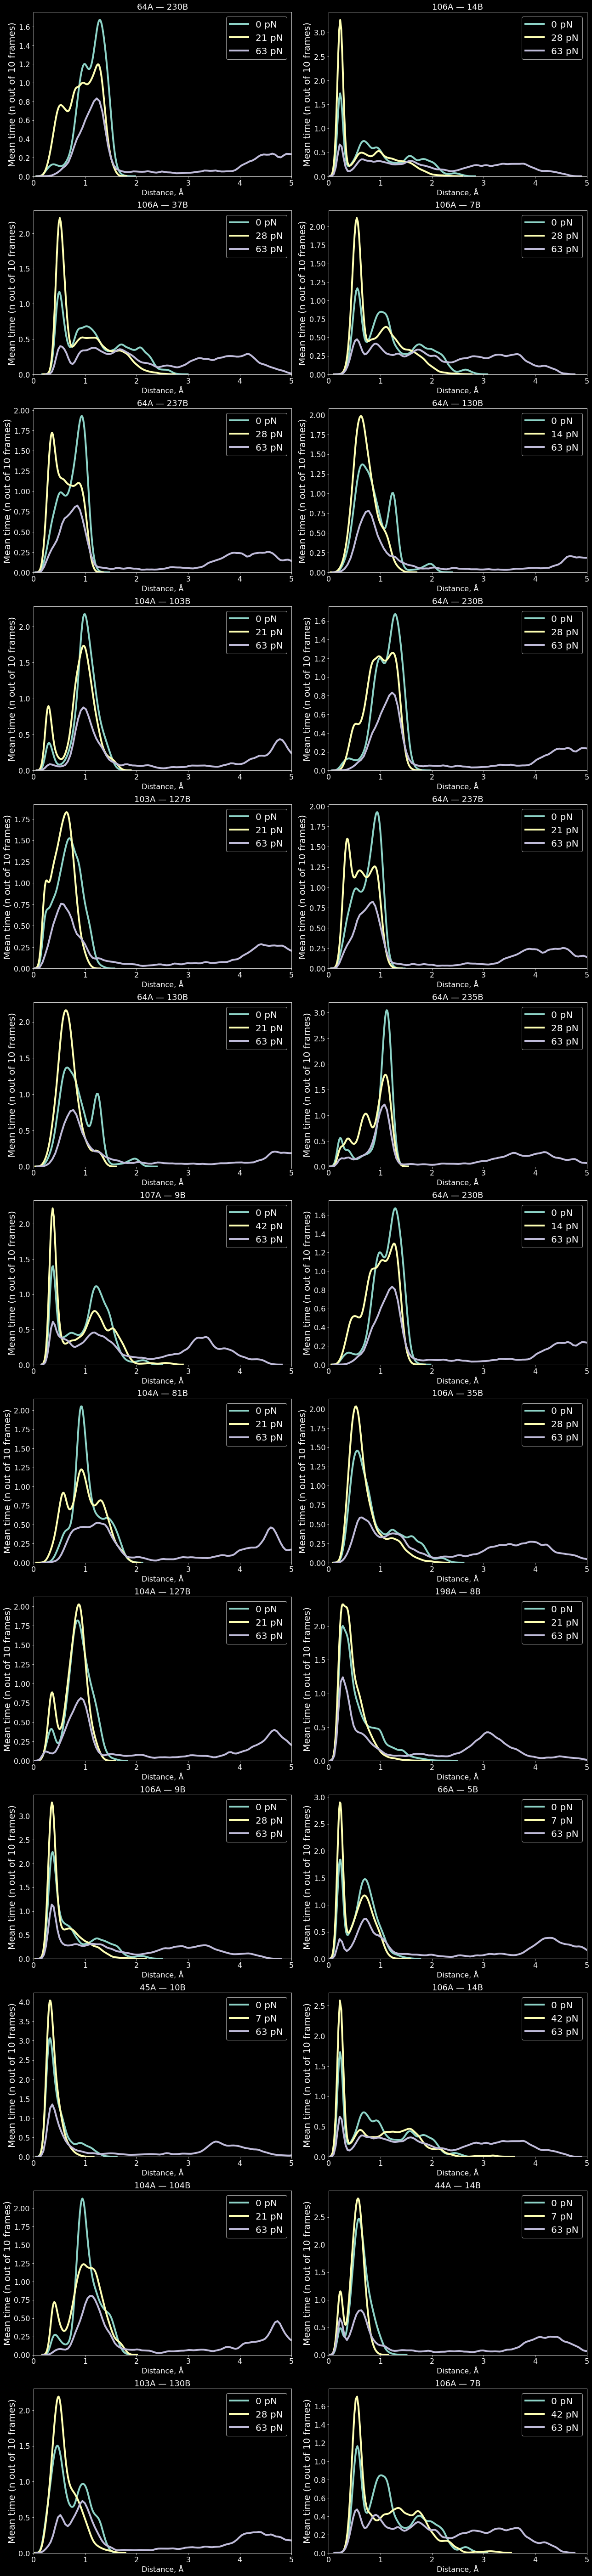

In [119]:
display_params = [
    (t[0], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[1]) for t in cand_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()

In [120]:
zero_force_flatten = whole_arr[:, 0, :, :].reshape(-1, whole_arr.shape[3])
zero_force_medians = np.median(zero_force_flatten, axis=0)
zero_force_contacts = zero_force_medians < 1

force_pairs_dict = dict()
results = []

for force in tqdm(range(1, FORCES), total=FORCES - 1):
    m_force_flatten = whole_arr[:, force, :, :].reshape(-1, whole_arr.shape[3])
    m_force_medians = np.median(m_force_flatten, axis=0)
    for i, (f, z) in enumerate(zip(m_force_medians.tolist(), zero_force_medians.tolist())):
        if f < .9 * z and f < 1:
            results.append((f, z, force, get_pair(i, FIRST_CHAIN)))

In [123]:
median_tuples = [t for t in sorted(results, key=lambda t: t[2] / t[1]) if t[0] < .6]

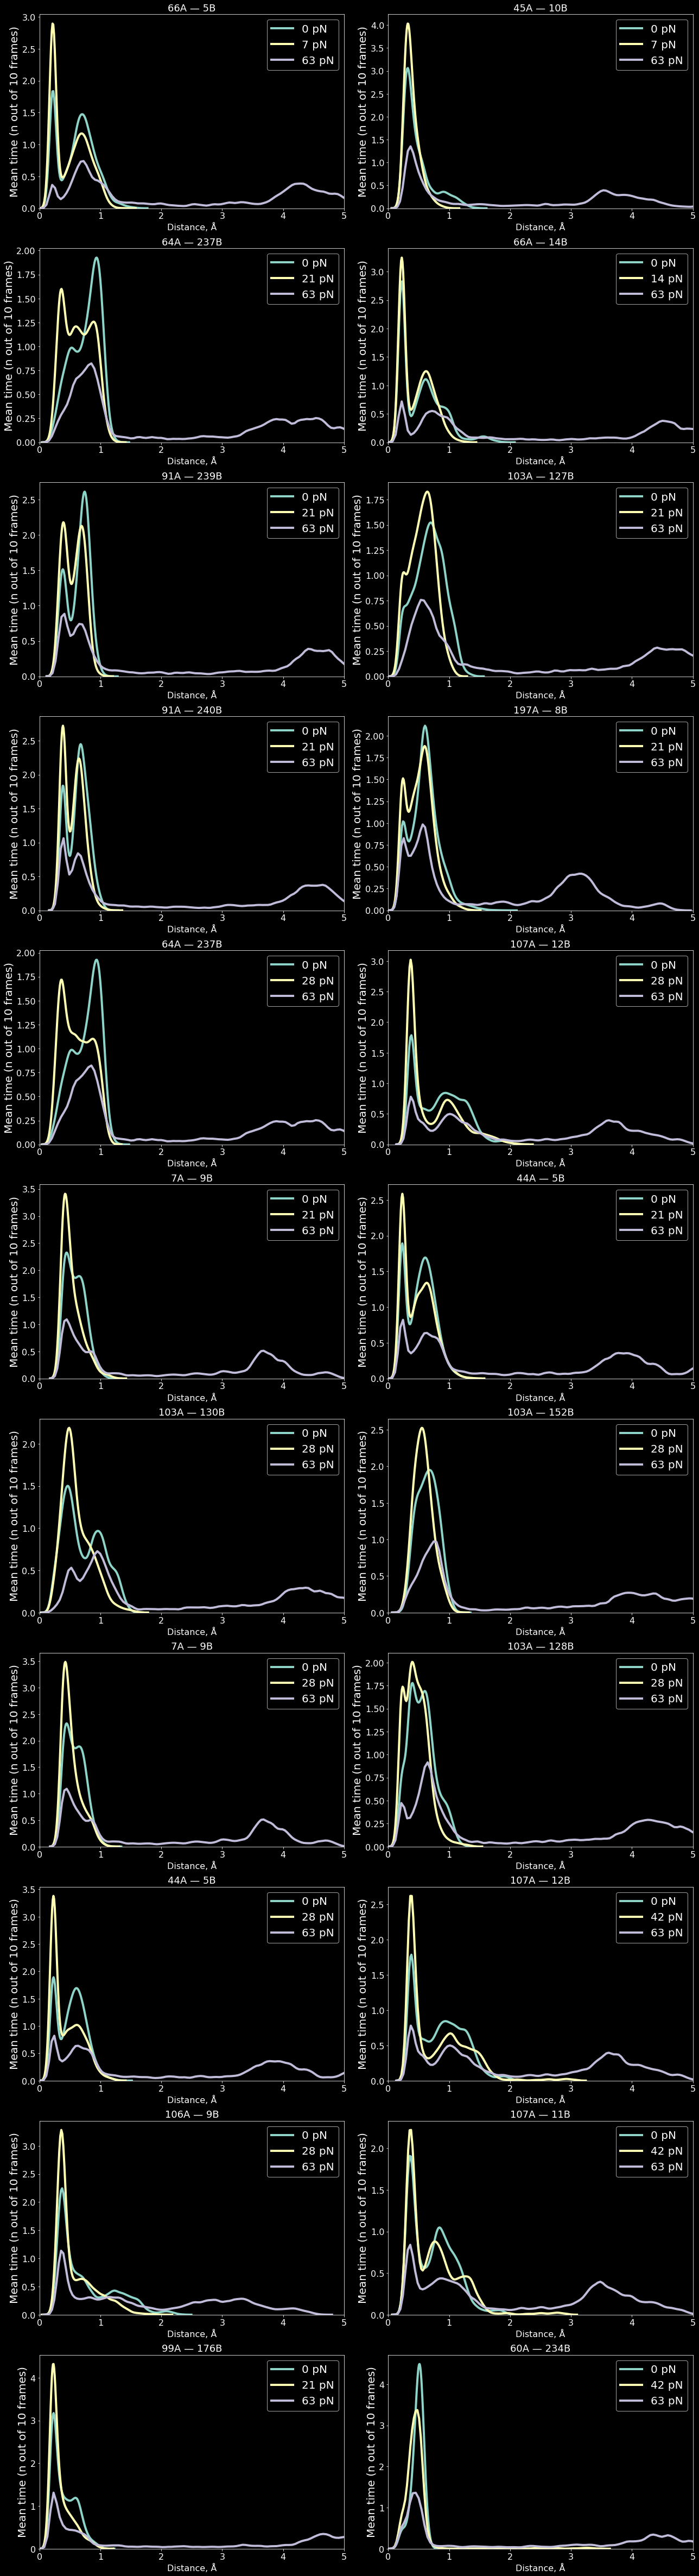

In [124]:
display_params = [
    (t[3], np.arange(9), np.array([0, 1, 2, 3, 4, 5, 6, 8, 9]), np.arange(9), t[2]) for t in median_tuples
]

fig = plt.figure(figsize=(18, 3 * len(display_params)))
plt.style.use('dark_background')
fig.patch.set_facecolor("xkcd:black")

for param_i, param in enumerate(display_params):
    f, s = param[0]
    pair_str = "{}A — {}B".format(f, s)
    r1, r2, r3 = param[1], param[2], param[3]
    force = param[4]
    cur_pair = get_index(f, s, FIRST_CHAIN)
    
    XMAX = 5
    YMAX = 4

    ylims = []
    axes = []
    
    ax = fig.add_subplot(len(display_params) // 2, 2, 1 + param_i * 1)
    cur_line = sns.kdeplot(whole_arr[r1, 0, :, cur_pair].flatten(), bw=.05, label="0 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_xlabel("Distance", fontdict={"size": 14})
    ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 14})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r2, force, :, cur_pair].flatten(), bw=.05, label="{} pN".format(force * 7), linewidth=4)
    ylims.append(cur_line.get_ylim())
    ax.set_title("{}".format(pair_str), fontdict={"size": 18})
    axes.append(ax)

    cur_line = sns.kdeplot(whole_arr[r3, 9, :, cur_pair].flatten(), bw=.05, label="63 pN", linewidth=4)
    ylims.append(cur_line.get_ylim())
    axes.append(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=20)
    
    for ax in axes:
        ax.set_xlim(0, 5)
        ax.set_ylim(0, np.max([l[1] for l in ylims]))
        
        [t.set_fontsize(16) for t in ax.get_xticklabels()]
        ax.set_xlabel("Distance, Å", fontdict={"size": 16})
        [t.set_fontsize(16) for t in ax.get_yticklabels()]
        ax.set_ylabel("Mean time (n out of 10 frames)", fontdict={"size": 20})
        
plt.tight_layout()